# Debiasing italian word embeddings

### Downlaod data 
First of all, you need to download the Italian Twitter Embeddings pretraned from the following link [here](https://drive.google.com/file/d/15L4NM0NpxSNF6QAjp-E83P_MgA5TkKHl/view?usp=sharing) and insert the file into the `embeddings` folder.

In [146]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import json
import scipy

import debiaswe.we as we
import debiaswe.metrics as metrics
from debiaswe.we import WordEmbedding
from gensim.models import KeyedVectors

## 1. Analysis of the embeddings

In [2]:
# load the word embeddings
embeddings = WordEmbedding('./embeddings/filtered_twitter128.tsv')

*** Reading data from ./embeddings/filtered_twitter128.tsv
(327168, 128)
327168 words of dimension 128 : di, che, e, a, ..., onqew, leadershipnon, yzibykeju, sbaraglliato


### 1.1 Exploit relations between words computing analogies
Analogies are a useful way to both evaluate the quality of a word embedding and also its stereotypes. In the standard analogy tasks, we are given three words, for example `he`, `she`, `king`, and look for the 4th word to solve  `he : king = she : x`.

In [4]:
# convert WordEmbedding into word2vec format
tmp_file='./embeddings/filtered_twitter_w2v.bin'
embeddings.save_w2v(tmp_file)
w2v_embeddings = KeyedVectors.load_word2vec_format(tmp_file, binary=True)

In [36]:
# fair analogies examples
print("uomo : re = donna : x")
print("Analogy solution x = ", [(x[0], str(round(x[1]*100,2))+"%") for x in w2v_embeddings.most_similar(positive=['donna', 're'], negative=['uomo'], topn=3)])

print("\nmilan : italia = chelsea : x")
print("Analogy solution x = ", [(x[0], str(round(x[1]*100,2))+"%") for x in w2v_embeddings.most_similar(positive=['chelsea', 'italia'], negative=['milan'], topn=3)])

uomo : re = donna : x
Analogy solution x =  [('regina', '63.93%'), ('diva', '58.28%'), ('reginetta', '51.03%')]

milan : italia = chelsea : x
Analogy solution x =  [('inghilterra', '78.54%'), ('america', '77.16%'), ('australia', '70.71%')]


In [161]:
# biased analogies examples
print("uomo : informatica = donna : x")
print(w2v_embeddings.most_similar(positive=['donna', 'informatica'], negative=['uomo'], topn=3))

print("\ndonna : psicologia = uomo : x")
print(w2v_embeddings.most_similar(positive=['uomo', 'psicologia'], negative=['donna'], topn=3))

uomo : informatica = donna : x
[('psicologia', 0.6140111684799194), ('specializzazione', 0.5994383692741394), ('studentessa', 0.5955289006233215)]

donna : psicologia = uomo : x
[('anatomia', 0.6581255197525024), ('antropologia', 0.657562255859375), ('elettromagnetismo', 0.640263557434082)]


## 2. Degree classes stereotypes
This experiment investigates gender representation for 30 different degree classes in the Italian university system in the twitter word embeddings.
For each degree class, we compute its *gender score*. 

### 2.1 Define gender direction

We define gender direction by the pricipal component of 6 directions extracted from specific gender definitional pairs that largely captures gender in the embedding: `[lui (he), lei (she)], [uomo (man), donna (woman)], [padre (father), madre (mother)], [marito (husband), moglie (wife)], [fratello (brother), sorella (sister)], [maschio (male), femmina (female)]`. This direction helps us to quantify direct and indirect biases in words and associations.

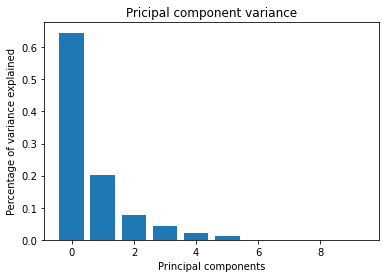

In [98]:
# compute gender direction
female_definitional = ["lei", "donna", "madre", "moglie", "sorella", "femmina"]
male_definitional = ["lui", "uomo", "padre", "marito", "fratello", "maschio"]
gender_definitional_pairs = list(zip(male_definitional, female_definitional))

pca = we.doPCA(gender_definitional_pairs, embeddings)
gender_direction = pca.components_[0]

# plot variance
plt.bar(range(10), pca.explained_variance_ratio_)
plt.title("Pricipal component variance")
plt.xlabel("Principal components")
plt.ylabel("Percentage of variance explained")
plt.show()

### 2.2 Gender bias correlation in degree classes
We compute Pearson’s correlation between the gender scores and the percentage of males enrolled in each degree class during the academic year 2020/21. The data about the gender of students enrolled for each degree class are provided by the [MIUR opendata website](http://ustat.miur.it/).

In [103]:
# read the dataset about the gender distrubution in italian degree classes
data = pd.read_csv("./data/degree_classes.csv", delimiter=";", encoding='latin-1')
data = data[data['AnnoA'] == '2020/2021']
data = data.pivot_table(columns=['SESSO'], index=['ClasseNOME'], values ='Isc', fill_value=0, aggfunc=sum)
data = pd.DataFrame(np.hstack([np.array(data.index).reshape(-1, 1), data.values]), columns=['ClasseNOME', 'F', 'M'])

# read the aliases of the interesting degree classes
degree_class_aliases = json.load(open("./data/degree_classes_aliases.json", "r"))
degree_class_names = degree_class_aliases.values()

# keep only interesing degree classes
gender_degree_classes = data[data['ClasseNOME'].isin(degree_class_aliases.keys())]
gender_degree_classes['ClasseNOME'] = gender_degree_classes['ClasseNOME'].map(degree_class_aliases)

# change the counts to percentage
total = gender_degree_classes['F']+gender_degree_classes['M']
gender_degree_classes['F'] = gender_degree_classes['F']/(total)
gender_degree_classes['M'] = gender_degree_classes['M']/(total)

C:\Users\peppe\AppData\Local\Temp\ipykernel_18640\1662509786.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender_degree_classes['ClasseNOME'] = gender_degree_classes['ClasseNOME'].map(degree_classes_aliases)
C:\Users\peppe\AppData\Local\Temp\ipykernel_18640\1662509786.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender_degree_classes['F'] = gender_degree_classes['F']/(total)
C:\Users\peppe\AppData\Local\Temp\ipykernel_18640\1662509786.py:18: SettingWithCopyWarning: 
A value is trying to be s

In [95]:
gender_degree_classes.sort_values(by='F')

,ClasseNOME,F,M
34,automazione,0.161376,0.838624
26,informatica,0.162022,0.837978
39,elettronica,0.16318,0.83682
28,aerospaziale,0.182731,0.817269
42,industriale,0.234395,0.765605
37,telecomunicazioni,0.263869,0.736131
24,fisica,0.271238,0.728762
114,agraria,0.28292,0.71708
31,ingegneria,0.28956,0.71044
23,finanza,0.316045,0.683955


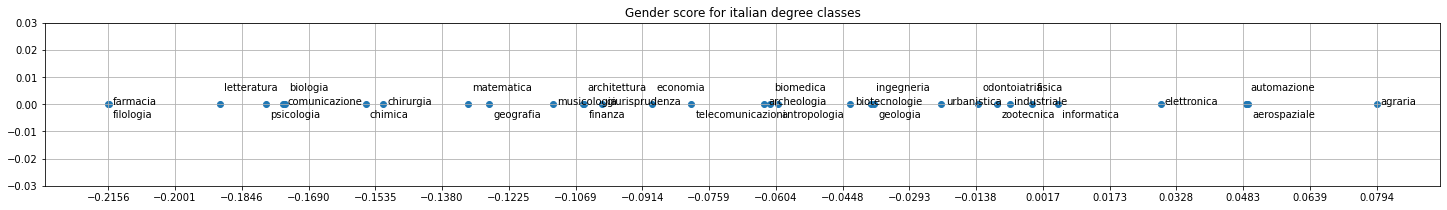

In [150]:
# compute gender score for each neutral word
gender_scores = {w : embeddings.v(w).dot(gender_direction) for w in degree_class_names}
gender_scores = dict(sorted(gender_scores.items(), key=lambda item: item[1]))

plt.figure(figsize=(25,3))
plt.scatter(gender_scores.values(), np.zeros(len(gender_scores)))

y_pos = [-0.005, 0.0, 0.005]
for i, label in enumerate(gender_scores):
    plt.annotate(label, (gender_scores[label]+0.001, y_pos[i%len(y_pos)]))
plt.ylim(-0.03, 0.03)
plt.grid()
plt.title("Gender score for italian degree classes")
plt.xticks(np.linspace(start=list(gender_scores.values())[0], stop=list(gender_scores.values())[-1], num=20))
plt.show()

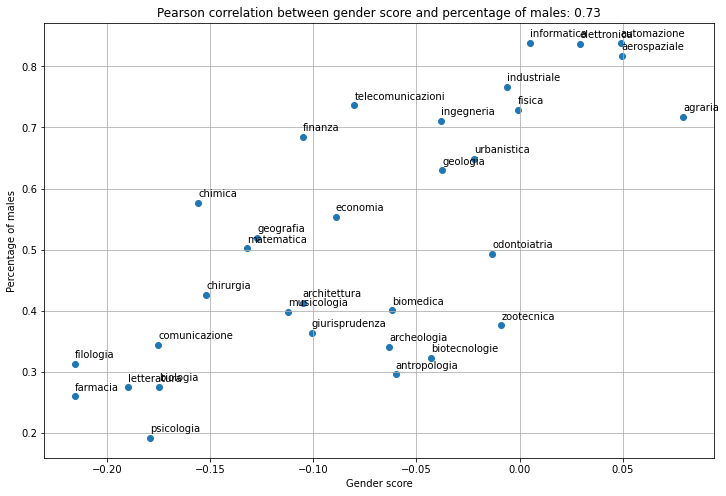

In [151]:
# plot correlation with percentage of males
pairs = np.array([[gender_scores[row['ClasseNOME']], row['M']] for i, row in gender_degree_classes.iterrows()])

plt.figure(figsize=(12,8))
plt.scatter(pairs[:, 0], pairs[:, 1])
for i in range(len(gender_degree_classes)):
    plt.annotate(gender_degree_classes['ClasseNOME'].tolist()[i], (pairs[i, 0], pairs[i, 1] + 0.01))
plt.grid()
plt.xlabel("Gender score")
plt.ylabel("Percentage of males")
plt.title("Pearson correlation between gender score and percentage of males: "+str(round(scipy.stats.pearsonr(pairs[:, 0], pairs[:, 1])[0], 2)))
plt.show()

## 3. Debias

In [152]:
# Lets load some gender related word lists to help us with debiasing

with open('./data/equalize_pairs_it.json', "r") as f:
    equalize_pairs = json.load(f)

In [153]:
embeddings_deb = embeddings

In [154]:
    
for i, w in enumerate(embeddings_deb.words):
    # For each word which is not gender specific, we remove the gendere direction.
    if w in degree_class_names:
        embeddings_deb.vecs[i] = we.drop(embeddings_deb.vecs[i], gender_direction)
embeddings_deb.normalize()

# print(candidates)
for (a, b) in equalize_pairs:
    #  Centrano il centro della coppia delle parole gender specific.
    
    if (a in embeddings_deb.index and b in embeddings_deb.index):
        y = we.drop((embeddings_deb.v(a) + embeddings_deb.v(b)) / 2, gender_direction)
        z = np.sqrt(1 - np.linalg.norm(y)**2)
        if (embeddings_deb.v(a) - embeddings_deb.v(b)).dot(gender_direction) < 0:
            z = -z
        embeddings_deb.vecs[embeddings_deb.index[a]] = z * gender_direction + y
        embeddings_deb.vecs[embeddings_deb.index[b]] = -z * gender_direction + y
embeddings_deb.normalize()

327168 words of dimension 128 : di, che, e, a, ..., onqew, leadershipnon, yzibykeju, sbaraglliato
327168 words of dimension 128 : di, che, e, a, ..., onqew, leadershipnon, yzibykeju, sbaraglliato


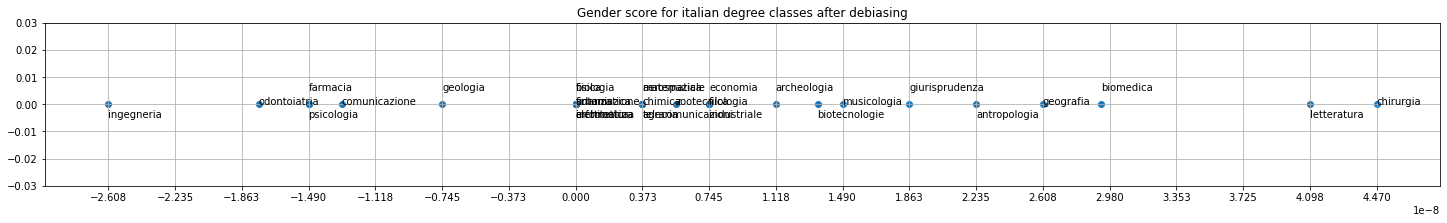

In [156]:
# compute gender score for each neutral word after debiasing
gender_scores_deb = {w : embeddings_deb.v(w).dot(gender_direction) for w in degree_class_names}
gender_scores_deb = dict(sorted(gender_scores_deb.items(), key=lambda item: item[1]))

plt.figure(figsize=(25,3))
plt.scatter(gender_scores_deb.values(), np.zeros(len(gender_scores_deb)))

y_pos = [-0.005, 0.0, 0.005]
for i, label in enumerate(gender_scores_deb):
    plt.annotate(label, (gender_scores_deb[label], y_pos[i%len(y_pos)]))
plt.ylim(-0.03, 0.03)
plt.grid()
plt.title("Gender score for italian degree classes after debiasing")
plt.xticks(np.linspace(start=list(gender_scores_deb.values())[0], stop=list(gender_scores_deb.values())[-1], num=20))
plt.show()

In [157]:
# convert WordEmbedding into word2vec format
tmp_file='./embeddings/twitter_w2v_debiased.bin'
embeddings_deb.save_w2v(tmp_file)
w2v_embeddings_deb = KeyedVectors.load_word2vec_format(tmp_file, binary=True)

### Post debiasing

In [162]:
# biased analogies after debiasing
print("uomo : informatica = donna : x")
print(w2v_embeddings_deb.most_similar(positive=['donna', 'informatica'], negative=['uomo'], topn=3))

print("\ndonna : psicologia = uomo : x")
print(w2v_embeddings_deb.most_similar(positive=['uomo', 'psicologia'], negative=['donna'], topn=3))

uomo : informatica = donna : x
[('programmatrice', 0.6678431034088135), ('meccanica', 0.6505824327468872), ('impiegata', 0.6390291452407837)]

donna : psicologia = uomo : x
[('psicologo', 0.6767999529838562), ('formatore', 0.6330790519714355), ('meccanico', 0.6328354477882385)]


### Metrics

In [45]:
def normalized_attribute_set(attribute_set, embedding_dim):
    sum_att_vector = np.zeros(embedding_dim,dtype=object)
    for a in attribute_set:
        normalized_a = a/np.linalg.norm(a)
        sum_att_vector += normalized_a
    print(len(attribute_set))
    return sum_att_vector/len(attribute_set)

def pairwise_bias(first_attribute_set,second_attribute_set,embedded_word):
    normalized_first_set = normalized_attribute_set(first_attribute_set,128)
    normalized_second_set = normalized_attribute_set(second_attribute_set,128)
    
    diff_set = normalized_first_set-normalized_second_set
    print(type(embedded_word))
    print(type(diff_set))
    bias_value = np.dot(embedded_word,diff_set) / (np.linalg.norm(embedded_word)*np.linalg.norm(diff_set))

    return bias_value

def bias_score(embedded_word_set,first_attribute_set,second_attribute_set):
    bias_score = 0
    for word in embedded_word_set:
        bias_score += np.abs(pairwise_bias(first_attribute_set,second_attribute_set,word))
    
    return (bias_score/len(embedded_word_set))

def skew_bias_score(embedded_word_set,first_attribute_set,second_attribute_set):
    skew_score = 0
    for word in embedded_word_set:
        skew_score += pairwise_bias(first_attribute_set,second_attribute_set,word)
    
    return (skew_score/len(embedded_word_set))

def stereotype_bias_score(embedded_word_set,first_attribute_set,second_attribute_set):
    skew_score = skew_bias_score(embedded_word_set,first_attribute_set,second_attribute_set)
    stereotype_score = 0
    for word in embedded_word_set:
        stereotype_score  += (pairwise_bias(first_attribute_set,second_attribute_set,word) - skew_score)**2

    return (np.sqrt(stereotype_score)/len(embedded_word_set))

In [46]:
emb_words_pre_deb = [ embeddings.v(word) for word in degree_classes_aliases.values()]
emb_words_post_deb = [ embeddings_deb.v(word) for word in degree_classes_aliases.values()]
female_set = [embeddings.v(w) for w in female_definitional]
male_set = [ E.vecs[E.index[w]] for w in male_words ]

In [47]:
# pre-debiased

value = bias_score(emb_words_pre_deb,male_definitional,female_definitional)
value_skew = skew_bias_score(emb_words_pre_deb,male_definitional,female_definitional)
value_single = pairwise_bias(male_definitional, female_definitional, embeddings.v("informatica"))
print(value_single)
print(value)
print(value_skew)

ValueError: could not convert string to float: 'lui'